<a href="https://colab.research.google.com/github/Soosembly/ResearchPaper/blob/main/VGGNet16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Very deep convolutional networks for large-scale image recognition

VGGNet은 신경망의 깊이가 모델의 성능에 미치는 영향을 조사하기 위해 해당 연구를 시작하였으며, 이를 증명하기 위해 3x3 concolution을 이용한 Deep CNNs를 제안하였다. VGGNet은 ILSVRC-2014 대회에서 GoogLeNet에 이어 2등을 차지하였으나, GoogLeNet에 비해 훨씬 간단한 구조로 1등인 모델보다 더욱 널리 사용되었다고 한다.

### window_size와 activation function 설정
- 3x3 convolution filters(stride:1)
- 2x2 convolution filters(stride:2)
- Activation function:ReLU
- 논문 표에서 conv3-64라고 써있는 것의 의미: 3x3의 windows_size를 갖고 사용한 window의 개수가 64개임을 의미함

# 01. Import Libraries

In [2]:
import torch
import torch.nn as nn # 신경망들이 포함됨
import torch.optim as optim # 최적화 알고리즘들이 포함됨
import torchvision
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴
from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
import matplotlib.pyplot as plt
import numpy as np

#02. Define the Model
## 코딩 편의를 위한 블럭 만들기
- conv layer가 2개 있는 block
- conv layer가 3개 있는 block

In [3]:
# conv_2_block
def conv_2_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model


In [4]:
# conv_3_block
def conv_3_block(in_dim, out_dim):
  model = nn.Sequential(
      nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
  )
  return model

## Define VGG16

- 3x3 합성곱 연산 x2 (채널 64)
- 3x3 합성곱 연산 x2 (채널 128)
- 3x3 합성곱 연산 x3 (채널 256)
- 3x3 합성곱 연산 x3 (채널 512)
- 3x3 합성곱 연산 x3 (채널 512)
- FC layer x3
- FC layer 4096
- 1x1xFC layer 4906
- 1x1xFC layer 1000




In [5]:
class VGG(nn.Module):
  def __init__(self, base_dim, num_classes=10):
    super(VGG, self).__init__()
    self.feature = nn.Sequential(
        conv_2_block(3, base_dim), # 64
        conv_2_block(base_dim, 2*base_dim), #128
        conv_3_block(2*base_dim, 4*base_dim), #256
        conv_3_block(4*base_dim, 8*base_dim), #512
        conv_3_block(8*base_dim, 8*base_dim), #512
    )


    # 평탄화된 특성의 크기를 자동으로 계산하기 위한 임시 텐서
    mock_tensor = torch.zeros((1, 3, 32, 32))
    mock_tensor = self.feature(mock_tensor)

    # CIFAR10 데이터셋에 맞게 완전 연결 계층 크기 조정
    flattened_size = mock_tensor.shape[1] * mock_tensor.shape[2] * mock_tensor.shape[3]
    self.fc_layer = nn.Sequential(
        nn.Linear(flattened_size, 4096),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(4096, 1000),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(1000, num_classes),
        )

  def forward(self, x):
      x = self.feature(x)
      x = x.view(x.size(0), -1)
      x = self.fc_layer(x)
      return x

# 데이터셋 변환 설정

In [6]:
# Transform 정의
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# CIFAR10 데이터 로드
cifar10_train = datasets.CIFAR10(root="../Data/", train=True, transform=transform, target_transform=None, download=True)
cifar10_test = datasets.CIFAR10(root="../Data", train=False, transform=transform, target_transform=None, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:12<00:00, 13225776.57it/s]


Extracting ../Data/cifar-10-python.tar.gz to ../Data/
Files already downloaded and verified


# DataLoader 설정
- CIFAR10은 ‘비행기(airplane)’, ‘자동차(automobile)’, ‘새(bird)’, ‘고양이(cat)’, ‘사슴(deer)’, ‘개(dog)’, ‘개구리(frog)’, ‘말(horse)’, ‘배(ship)’, ‘트럭(truck)’로 10개의 클래스로 구성되어 있는 데이터셋
- CIFAR10에 포함된 이미지의 크기는 3x32x32로, 이는 32x32 픽셀 크기의 이미지가 3개 채널(channel)의 색상로 이뤄져 있다는 것을 뜻

In [7]:
# DataLoader 설정
train_loader = DataLoader(cifar10_train, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(cifar10_test, batch_size=64, shuffle=False, num_workers=2)


## Model, loss, optimizer 선언

In [8]:
# 학습률 및 에포크 수 설정
batch_size = 100
learning_rate = 0.0002
num_epochs = 100


# 모델 인스턴스 생성 및 장치 할당
# device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# VGG 클래스를 인스턴스화
model = VGG(base_dim=64).to(device)

# 손실함수 및 최적화함수 설정
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## TRAIN

In [9]:
# 손실 기록을 위한 배열 초기화
loss_arr = []

# 학습 과정
for epoch in range(100):  # num_epochs 대신 직접 값 지정
    total_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_arr.append(avg_loss)
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/100], Loss: {avg_loss:.4f}')

Epoch [1/100], Loss: 2.0696
Epoch [11/100], Loss: 0.3573
Epoch [21/100], Loss: 0.1006
Epoch [31/100], Loss: 0.0553
Epoch [41/100], Loss: 0.0500
Epoch [51/100], Loss: 0.0334
Epoch [61/100], Loss: 0.0257
Epoch [71/100], Loss: 0.0654
Epoch [81/100], Loss: 0.2195
Epoch [91/100], Loss: 0.0251


## TRAIN 데이터셋 시각화

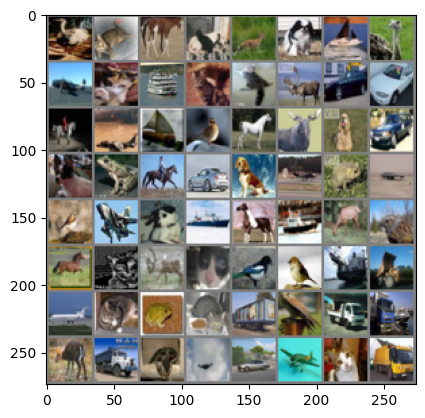

 bird   cat horse   cat  deer   dog  ship  bird plane   cat  ship   cat   cat  deer   car   car horse plane  ship  bird horse  deer   dog   car   dog  frog horse   car   dog plane  frog plane  bird plane   dog  ship horse  ship  deer  bird horse   cat  deer   cat  bird  bird  ship truck plane   cat  frog   cat truck  bird truck truck  deer truck   cat plane   car plane   cat truck


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# label(정답) 출력
# 여기서 len(labels)를 사용합니다.
print(" ".join('%5s' % classes[labels[j]] for j in range(len(labels))))

## loss 시각화

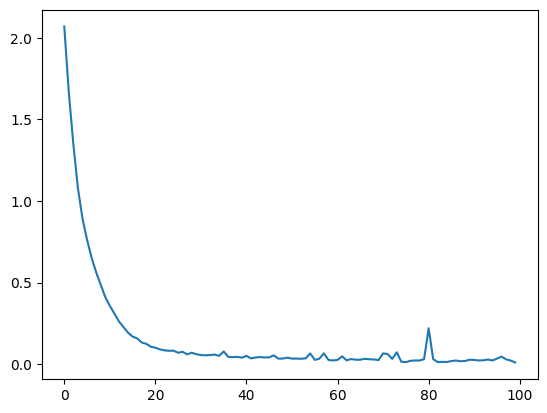

In [14]:
# 손실 그래프 표시
plt.plot(loss_arr)
plt.show()

## Test 결과

In [15]:
# 테스트 과정
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total}%')

Accuracy of the model on the test images: 81.2%
